In [1]:
%load_ext autoreload
%autoreload 2

import fooof
from fooof.sim.gen import gen_aperiodic      # for looking at aperiodic details
from fooof.plts.spectra import plot_spectrum # for looking at aperiodic details
#from fooof.plts.annotate import plot_annotated_peak_search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat
import math

from utils.data_utils import load_and_fit, invert_peak_data
from utils.plot_tools import plotFlatComps, peakPlot, peakDataScatter, exponentPlot, peakDistr

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Investigating spectra

- How do oscillations relate to dipole brain region?
- So far have been looking across components, not conditions (4 avg'd curves)

Other things:
- To see goodness of fit: fg.get_params('r_squared')

## FOOOF Settings

`peak_width_limits` sets the possible lower- and upper-bounds for the fitted peak widths.

`max_n_peaks sets` the maximum number of peaks to fit.

`min_peak_height` sets an absolute limit on the minimum height (above aperiodic) for any extracted peak.

`peak_threshold` sets a relative threshold above which a peak height must cross to be included in the model.

`aperiodic_mode` defines the approach to use to parameterize the aperiodic component.

## [Returning parameters](https://fooof-tools.github.io/fooof/generated/fooof.FOOOF.html#fooof.FOOOF.get_params) `.get_params()` 

`peak_params`
- CF: center frequency of the extracted peak
- PW: power of the peak, over and above the aperiodic component
- BW: bandwidth of the extracted peak

`aperiodic_params`
- exponent

#### Resources
- https://fooof-tools.github.io/fooof/generated/fooof.FOOOFGroup.html
- https://fooof-tools.github.io/fooof/#

### Testing grounds: changing `min_peak_height` to find components w/o oscillations

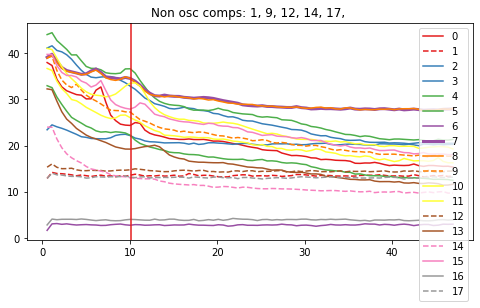

In [3]:
p_spectrum = loadmat(f'./data/spectra/dip_only/brian_diponly_{3}_spectra.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = specdata.mean(0)[0]
fg = fooof.FOOOFGroup(aperiodic_mode='fixed', verbose = False, min_peak_height = 0.025)
fg.fit(specfreqs, group_spec.T, [3, 40])
oscs = fg.get_params('peak_params', 'CF')
bumpy_comps = set([int(i) for i in oscs[:,1]])

n_ = group_spec.shape[1]
color = plt.cm.Set1(np.linspace(0, 1,n_)) #color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
flat_comps = 'Non osc comps: '
plt.figure(figsize=(8,4))
for i in range(n_):
    lw = 1.5
    linestyle = '-'
    if i not in bumpy_comps:
        linestyle = '--'
        flat_comps += "{}, ".format(i)
    if i == 7: lw = 3
    plt.plot(specfreqs[:84], group_spec[:,i][:84], linestyle = linestyle, marker='',markevery=[17],label = str(i), lw = lw)
plt.axvline(10.151271039)
plt.legend()
plt.title(flat_comps)
plt.show()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



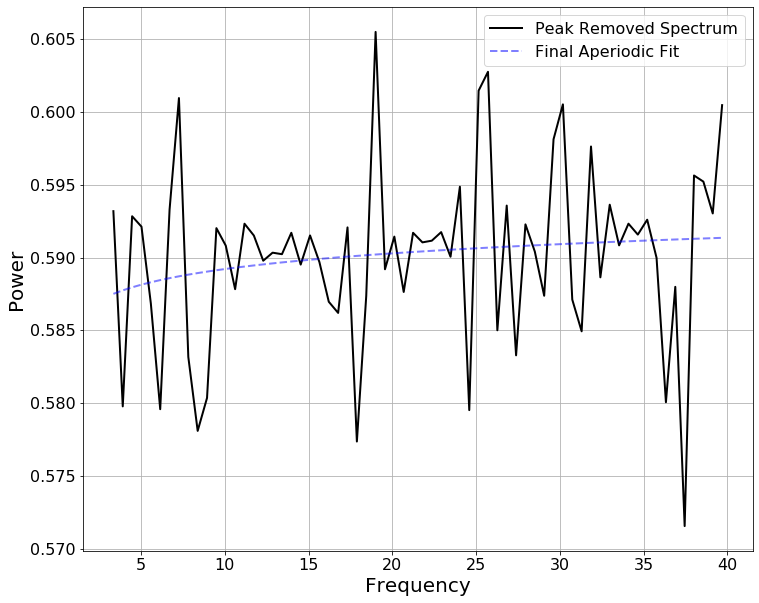

In [8]:
test_spec = group_spec[:,16]; plt_log = 0;
fm = fooof.FOOOF(aperiodic_mode='fixed')
fm.add_data(specfreqs,test_spec, [3, 40])
fm.fit(specfreqs, test_spec, [3, 40])
_, ax = plt.subplots(figsize=(12, 10))
plot_spectrum(fm.freqs, fm._spectrum_peak_rm, plt_log,
              label='Peak Removed Spectrum', color='black', ax=ax)
plot_spectrum(fm.freqs, fm._ap_fit, plt_log, label='Final Aperiodic Fit',
              color='blue', alpha=0.5, linestyle='dashed', ax=ax)

In [45]:
exponent = group_df[f'cluster {10}']['spectral exponent'][6]
f = lambda x: 1/(x**-exponent)
x_val = group_df[f'cluster {10}']['peak data']['CF'][3][0]
y_coord =  10**group_df[f'cluster {10}']['peak data']['PW'][3][0] #+ 10**f(x_val)

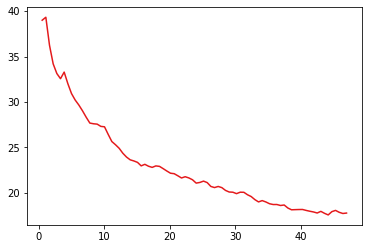

In [42]:
plt.plot(specfreqs[:84], group_spec[:,9][:84])

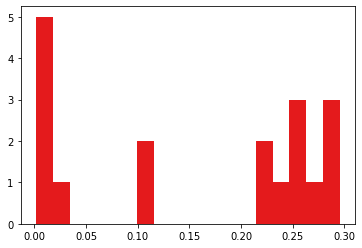

In [10]:
plt.hist(fg.get_params('aperiodic_params', 'exponent'), bins=18)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

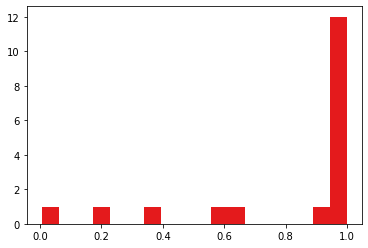

In [13]:
plt.hist(fg.get_params('r_squared'), bins=18); plt.show

# Load and fit data

Omit slopes lower than 0.05 (rough estimate) or goodness of fit
- Min peak height really a ratio 10^min_peak_height ~ 1.06

In [7]:
thresh = 0.1
group_df = load_and_fit(dimension = 'component', freqrange = [3,35], omit_r2 = 0.7, min_peak_height = .025)
list_peaks = 0
if list_peaks:
    for i, cl in enumerate(range(3,15)):
        peaks = group_df['cluster {}'.format(cl)]['peak data']['CF'][:,0]
        print('===Cluster {} oscillation freqs ==='.format(cl))
        peaks = sorted(peaks)
        for p in peaks:
            print('{:1.1f}'.format(p), end = ', ') #print with 1 decimal place
        print('\n')

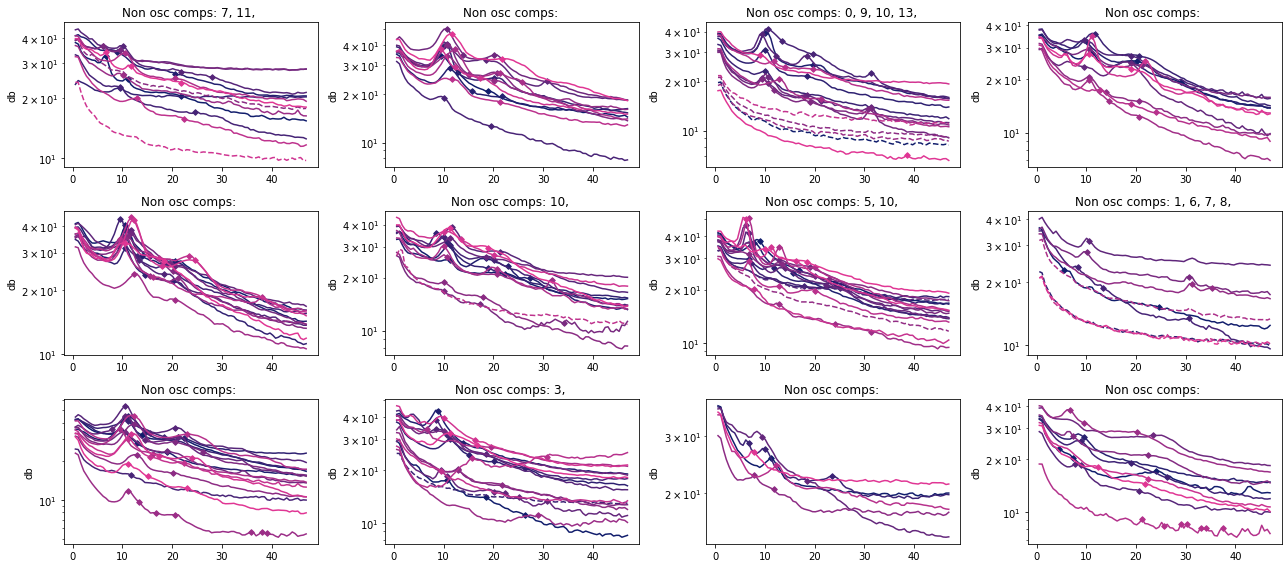

In [10]:
f = plt.figure(figsize=[18,8])
plotFlatComps(group_df, mark_peak = True) #warning: peak markers are at integer locations so may appear offset

save = 0
if save: f.savefig('./fig/fig', dpi = 300)

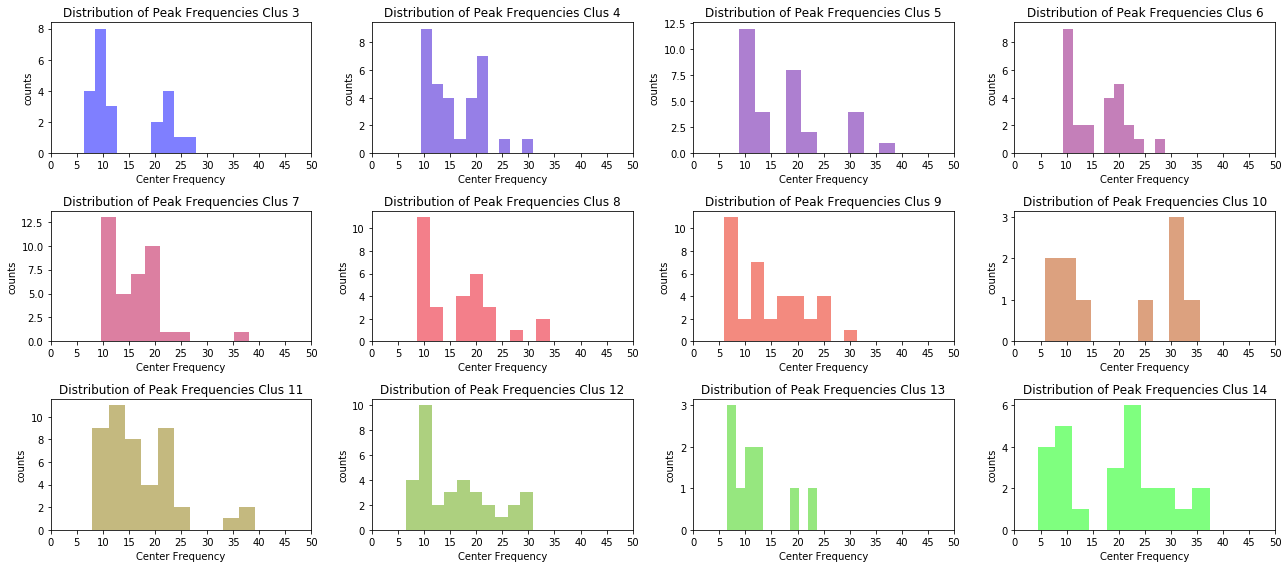

In [22]:
plt.figure(figsize=[18,8])
peakPlot(group_df, 'CF', plt_format = 'subplots')

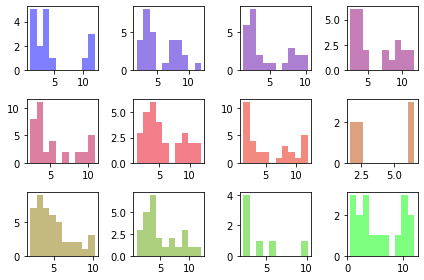

In [5]:
peakPlot(group_df, 'BW', plt_format = 'subplots')
plt.show()

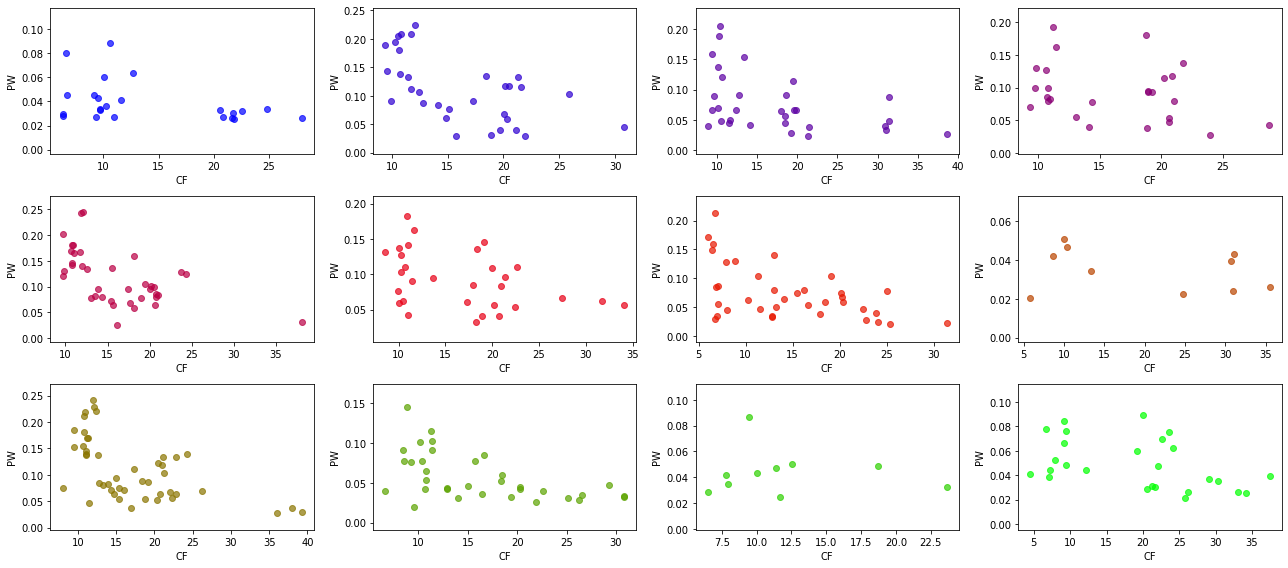

In [7]:
plt.figure(figsize=[18,8])
#peakDataScatter(group_df) #
peakDataScatter(group_df, measures = ['CF','PW'])

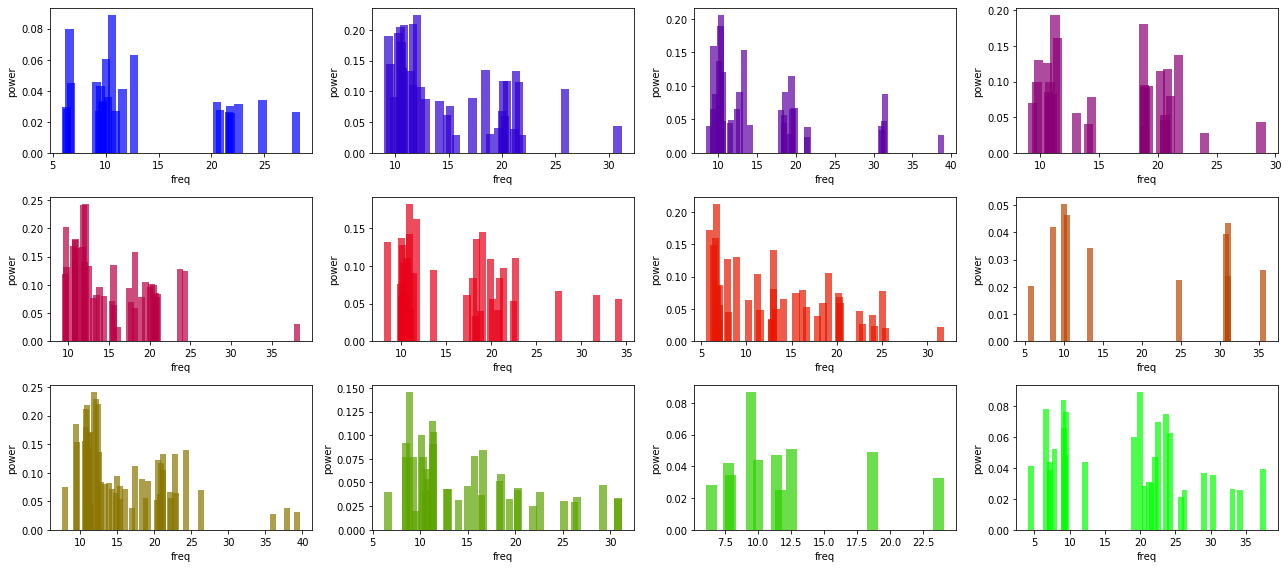

In [6]:
plt.figure(figsize=[18,8])
#peakDistr(group_df, order = 'sorted')
#peakDistr(group_df, plt_format = 'layered')
peakDistr(group_df)

# Ratio Analysis

(array([36., 31., 69., 23.,  7.,  8., 10.,  9.,  8.,  1.,  0.,  1.,  0.,
         0.,  1.]),
 array([1.12761222, 1.41111586, 1.69461951, 1.97812316, 2.26162681,
        2.54513046, 2.82863411, 3.11213776, 3.39564141, 3.67914506,
        3.96264871, 4.24615236, 4.529656  , 4.81315965, 5.0966633 ,
        5.38016695]),
 <a list of 15 Patch objects>)

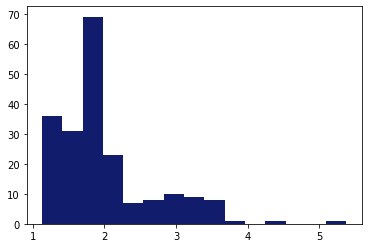

In [31]:
def calc_ratios(fit_data):
    """Compute ratio between oscillation freqs for all components, if multiple oscillations in spectrum"""
    ratios = dict()
    ratio_list = []
    for cl in range(3,15):        
        peak_data = fit_data['cluster {}'.format(cl)]['peak data']['CF']
        osc_dict = invert_peak_data(peak_data) #easier to read format
        ratios['clust %s'%cl] = dict()
        for c in osc_dict.keys():
            if len(osc_dict[c]) > 1:
                freqs = osc_dict[c]
                ratios_c = []
                curr_denom = freqs[0]
                for f in freqs[1:]:
                    ratios_c.append(f/curr_denom)
                    ratio_list.append(f/curr_denom)
                    #curr_denom = f
                ratios['clust %s'%cl][c] = ratios_c
                
    return ratios, ratio_list

rat, rat_l = calc_ratios(group_df)
plt.hist(rat_l, bins = 15)

# Modality separation

In [ ]:
def id_modes(fit_data):
    """Separating components by mu/alpha and beta"""
    alpha = []
    beta = []
    oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'beta' : [13,30], 'gamma' : [30,90]}
    for o in oscillations.keys():
        o_range = oscillations[o]
        min_, max_ = o_range[0], o_range[1]
            for i, cl in enumerate(range(3,15)):
                peak_data = fit_data['cluster {}'.format(cl)]['peak data']['CF']
                o_peaks = [] # peaks at oscillation o for cluster cl
                clus_peaks = peaks[i]
                for peak in clus_peaks:
                    if min_ <= peak[0] <= max_:
                        o_peaks.append(peak)

                if len(o_peaks) == 4:
                    pass

# Comparison chart
Originally done in MATLAB for ERPs

threshold 0.02

indices: PL, PR, TL, TR

3 statistics: freq, amplitutde, exponent

In [2]:
group_df2 = load_and_fit(dimension = 'condition', freqrange = [3,40], min_peak_height=0, omit_r2=0.7)
peaks = []
for i, cl in enumerate(range(3,15)):
    peaks.append(group_df2['cluster {}'.format(cl)]['peak data']['CF']) #[:,0]) 
#oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'beta' : [13,30], 'gamma' : [30,90]}
oscillations = {'delta' : [0.5,4], 'theta' : [4,8], 'alpha' : [8,13], 'theta-alpha': [4,13], 'beta' : [13,30], 'gamma' : [30,90]} # with theta/alpha

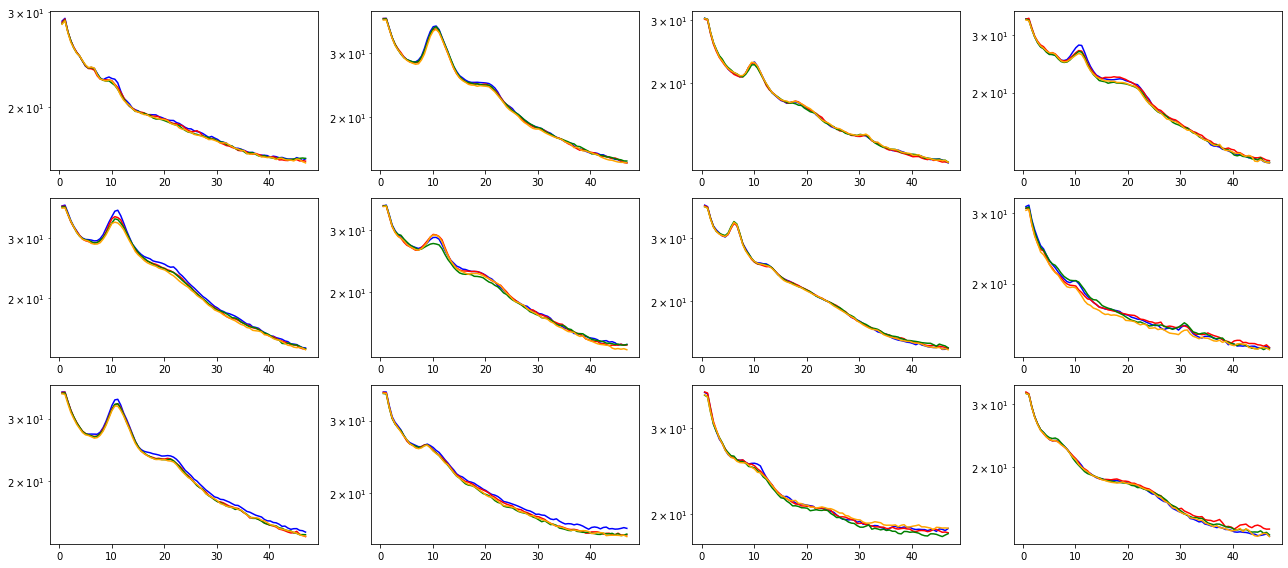

In [42]:
f = plt.figure(figsize=[18,8])
plotFlatComps(group_df2, mark_peak = True, dimension = 'condition')

### peaks format should be [freqs, pow, condition]
- though freq differences may be interesting as well

shape is 2 x 8 (2x2 freqs, 2x2 peak diff )

In [3]:
group_df2['cluster {}'.format(13)]['peak data']['CF']

array([[ 7.60460379,  0.        ],
       [10.70467258,  0.        ],
       [23.53136524,  0.        ],
       [10.24757059,  1.        ],
       [23.29629652,  1.        ],
       [24.4419159 ,  1.        ],
       [10.09271404,  2.        ],
       [23.81328201,  2.        ],
       [31.7301746 ,  2.        ],
       [ 6.23875572,  3.        ],
       [10.25044306,  3.        ],
       [24.81426284,  3.        ],
       [33.64781744,  3.        ],
       [33.81815164,  3.        ],
       [36.27487544,  3.        ],
       [38.81694802,  3.        ]])

In [4]:
diffs = dict()
for o in oscillations.keys():
    #print('++++++OSC', o)
    o_range = oscillations[o]
    min_, max_ = o_range[0], o_range[1]
    o_diffs = {'x':[], 'y':[], 'cl':[]} # to have x and y arrays
    
    for i, cl in enumerate(range(3,15)): #loop through clusters
        o_peaks = [] # peaks at oscillation o for cluster cl, make sure these are indexed properly
        clus_peaks = peaks[i]
        #this case assumes 4 peaks distr across conditions
        for peak in clus_peaks:
            if min_ <= peak[0] < max_: # if in peak range
                o_peaks.append(peak)
        #loop over conditions, if more than 1, avg the heights of the two 
        # ... code
                
        if len(o_peaks) == 4: # What do you do if more than 4?
            RL_P = o_peaks[1][0] - o_peaks[0][0]; RL_T = o_peaks[3][0] - o_peaks[2][0] # PR - PL; TR- TL
            PT_L = o_peaks[0][0] - o_peaks[2][0]; PT_R = o_peaks[1][0] - o_peaks[3][0] # PL - TL ; PR - TR

            RL = np.mean([RL_P, RL_T]) # mean([(PR - PL), (TR - TL)])
            PT = np.mean([PT_L, PT_R]) # mean([(PL - TL), (PR - TR)]) 

            o_diffs['x'].append(RL)
            o_diffs['y'].append(PT)
            o_diffs['cl'].append('  {}'.format(cl))
        #print('CLUS',cl,'\n', o_peaks)        
    
    if len(o_diffs['x']) != 0:
        diffs[o] = o_diffs

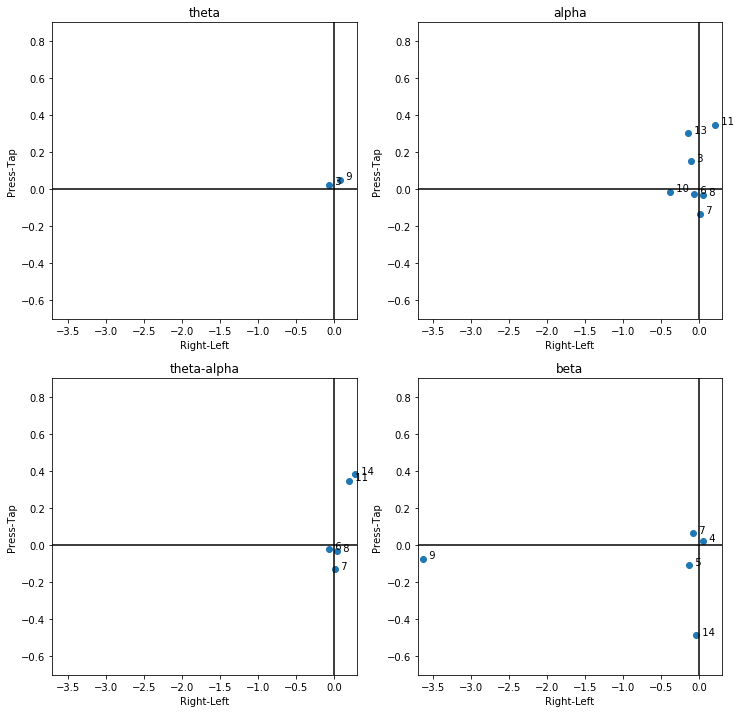

In [40]:
plt.figure(figsize=[12,12])
for i, o in enumerate(diffs.keys()):
    plt.subplot(2,2,i+1)
    x, y = diffs[o]['x'], diffs[o]['y']
    plt.scatter(x,y)
    plt.ylim([-0.7, 0.9]); plt.xlim([-3.7, 0.3])
    for t_i, txt in enumerate(diffs[o]['cl']):
        plt.annotate(txt, (x[t_i], y[t_i]))
    plt.axhline(0, color = 'k'); plt.axvline(0, color = 'k')
    #plt.tight_layout()
    plt.title(o)
    plt.xlabel('Right-Left'); plt.ylabel('Press-Tap');

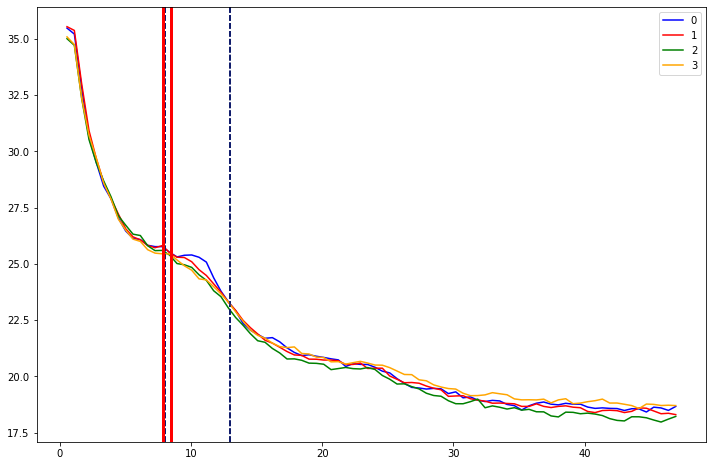

In [21]:
p_spectrum = loadmat('./data/spectra/dip_only/brian_diponly_{}_spectra.mat'.format(13))
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])
colors = ['b','r','g','orange'] # PL, PR, TL, TR
plt.figure(figsize=[12,8])
for i in range(4):
    plt.plot(specfreqs[:84], group_spec[i][:84], color = colors[i], label = str(i))
    #plt.xlim([5,14])
    # theta - alpha range
     plt.axvline(4, linestyle = '--'); plt.axvline(13, linestyle = '--')
        #cl14 peaks
#     plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)
    plt.axvline(8.5, color = 'red', lw = 3);     plt.axvline(7.85, color = 'red', lw = 3)

plt.legend()

In [ ]:
single_spec_fit = dict.fromkeys(['cluster {}'.format(i) for i in range(3,15)])
for k in single_spec_fit.keys():
    single_spec_fit[k] = {'PR':[], 'PL':[], 'TL':[], 'TR':[]}    

# Some tests 
Just to see how to use FOOOF and how to load exported spectral data
- Notice the variance in the non averaged spectrum.  

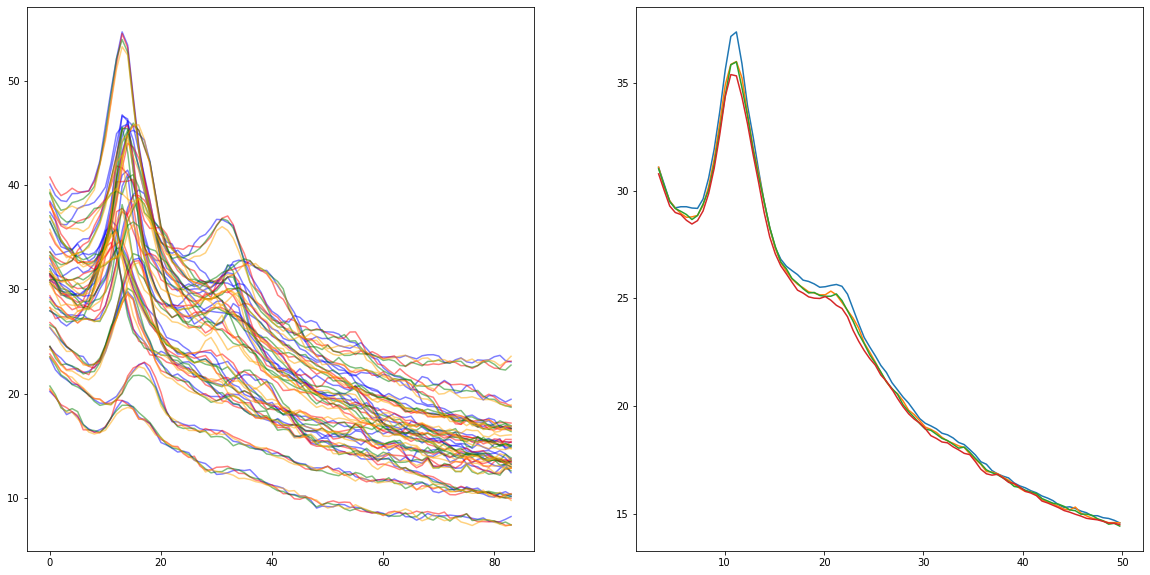

In [6]:
# data from dipole location + ERSP clustering; cluster 5
p_spectrum = loadmat('./data/spectra/dip5_specdata.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']

group_spec = np.array([specdata[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
colors = ['b','r','g','orange']
for i in range(4):
    plt.plot(specdata[i][0], color = colors[i], alpha = 0.5)

plt.subplot(1,2,2)
for i in range(4):
    plt.plot(specfreqs, group_spec[i])
    
#plt.legend()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
            

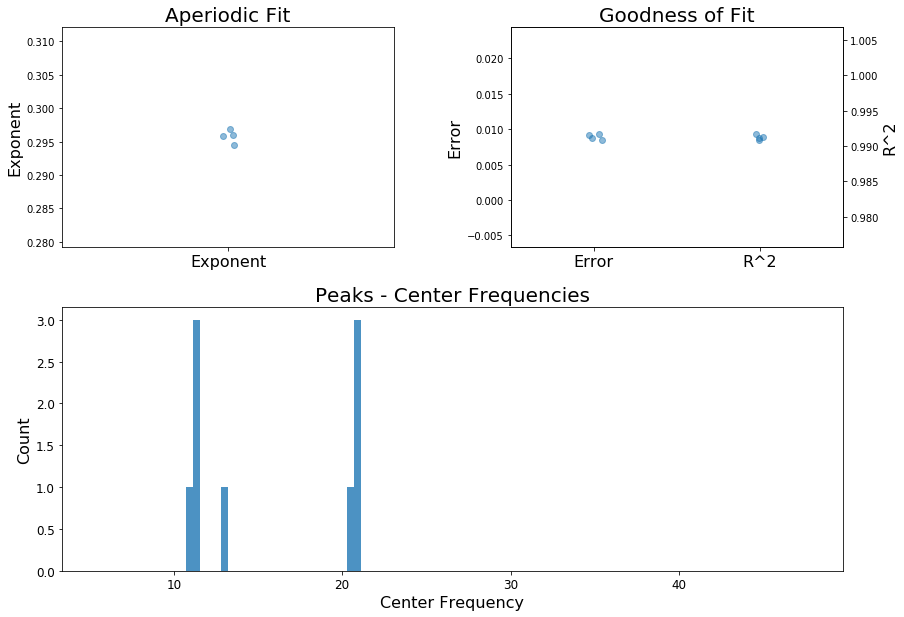

In [42]:
fg = fooof.FOOOFGroup()
fg.fit(specfreqs, group_spec)
freqrange = [3,50]
fg.report(specfreqs, group_spec, freqrange)

## Single FOOOF - One condition


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

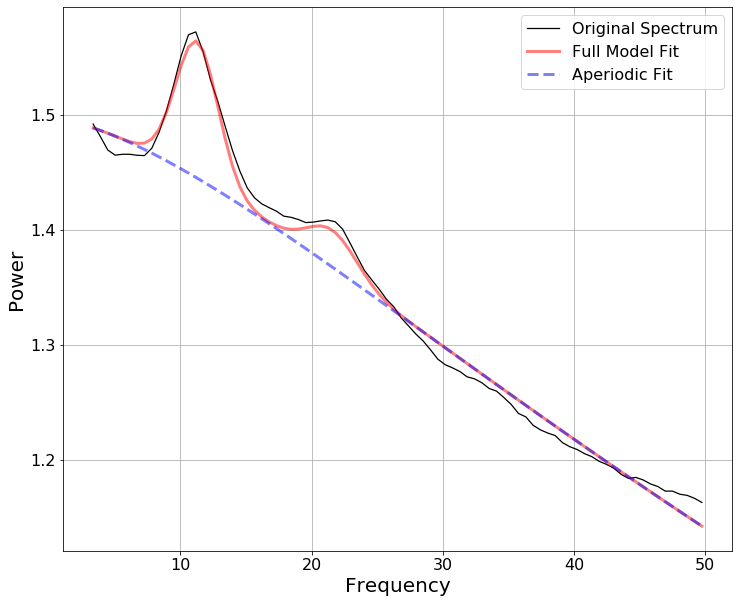

In [4]:
fg = fooof.FOOOF(aperiodic_mode='knee')
fg.fit(specfreqs, group_spec[0])
freqrange = [3,50]
fg.report(specfreqs, group_spec[0], freqrange)

# All dipole only clusters

This spectrum has 229 points for some reason

In [10]:
dip_only_spec = loadmat('./data/dip_only/brian_diponly_all_spectra.mat')


In [18]:
dip_only_spec['specdata'][0][0].shape


(229, 11)

In [20]:
dip_only_spec['specfreqs'].shape

(1, 229)

In [29]:
dip_only_spec3 = loadmat('./data/dip_only/brian_diponly_3_spectra.mat')
specfreqs3, specdata3 = dip_only_spec3['specfreqs'][0], dip_only_spec3['specdata']

group_spec3 = np.array([specdata3[i][0].mean(1) for i in range(4)])# shaped 4x84, averaged across 16 components

In [30]:
dip_only_spec3['specdata'][0][0].shape

(229, 18)

In [34]:
group_spec3.shape

(4, 229)

In [33]:
group_spec.shape

(4, 84)